## Description
This notebook plots fields (test loss, train loss) for different batch sizes on a given architecture.


In [133]:
import numpy as np
import glob
import argparse
import logging
import itertools
import sys
import scipy as sp
import scipy.stats
import os
import matplotlib
import matplotlib.pyplot as plt

In [140]:
"""
UTILITIES FOR PARSING LOGS
"""
MAX_NUM_ITERATIONS = 15000 # 40 epochs for 32 bS is 62k
UPDATE_PERIOD = lambda x: (x // (512 * 4)) if x >= (512*4) else 1
# LOG_PERIOD = {
#     32: 10,
#     64: 10,
#     128: 10,
#     256: 10,
#     512: 10,
#     1024: 10,
#     2048: 10,
#     4096: 10,
#     4096*2: 50/UPDATE_PERIOD(4096*2),
#     4096*4: 50/UPDATE_PERIOD(4096*4),
#     4096*8: 50/UPDATE_PERIOD(4096*8)
# }



MAX_NUM_LINES = MAX_NUM_ITERATIONS // max(LOG_PERIOD.values()) # iterations / 10 since we store every 10 iterations
def parse_line(s):
    """
    Parse a line of the log file!
    """
    s = s[1:-2].strip().replace(' ','').replace('"','')
    fields = s.split(',')
    d = {}
    for field_val_pair in fields:
        k, v = field_val_pair.split(':')
        v = float(v)
        d[k] = v
    return d

def get_field_arr(dicts, field='test_acc', remove_zeros=True, period=1):
    """
    Get the values of a field through all iterations!
    """
    max_iteration = max([int(d['iteration']) for d in dicts])
    print(max_iteration)
    result = [0.]*max_iteration
    period = max_iteration // len(dicts)
    
    for i, d in enumerate(dicts):
        #if i % period == 0:
        iteration = int(d['iteration'] )
        if iteration > MAX_NUM_ITERATIONS:
            break
        field_val = d[field]
        for k in range(i, (i+1)*period):
            result[k] = field_val
    
    if remove_zeros and 0.0 in result:
        first_0 = result.index(0.0)
        return result[:min(MAX_NUM_ITERATIONS, first_0)]
    return result[:MAX_NUM_ITERATIONS]
    #else:
    #    return result[:MAX_NUM_LINES]

def parse_batch_size(file_str):
    bs_ind = file_str.rindex('bs_')
    after_bs = file_str[bs_ind + 3:]
    batch_size = int(after_bs[:after_bs.index('_')])
    return batch_size

In [141]:
"""
EXPERIMENT PARAMETERS
"""
LOGDIR = './logs'
EXPERIMENT = 'baseline_resnet34_cifar10'
TITLE = 'ResNet34 on CIFAR10'

In [142]:
"""
PLOTTING PARAMETERS
"""
FIELDS_TO_PLOT = ['train_loss', 'test_loss', 'train_acc', 'test_acc']
ALL_PLOT_FIELDS = ['train_loss', 'test_loss']
FINAL_PLOT_FIELDS = ['train_acc', 'test_acc']

PRETTY_FIELD_NAMES = {
    'train_loss': 'Train Loss',
    'test_loss': "Test Loss",
    'train_acc': "Train Accuracy",
    'test_acc': "Test Accuracy"
}

FIELD_LINETYPES = {
    'train_loss': '-',
    'test_loss': '--',
    'train_acc': '-',
    'test_acc': '--'
}

BS_COLORS = {
    128: '#884dc6',
    256: '#749b50',
    512: '#d35a95',
    1024: '#7192be', 
    2048: '#be6741',
    4096: '#6c3a60'
}

In [143]:
"""
*** RERUN THIS CELL TO LOAD LOG DATA ***
"""
results = {}

for field in FIELDS_TO_PLOT:
    results[field] = {}
    log_file_strs = glob.glob(os.path.join(LOGDIR, EXPERIMENT + '_*/log.txt'))
    assert len(log_file_strs) > 0, "Need to have logs to parse!"
    
    # get bs, log_file_for_bs tuples
    bs_log_file_pairs = sorted(list(map(lambda log_file_str: \
                    (parse_batch_size(log_file_str), log_file_str), log_file_strs)),
                    key=lambda x: x[0])
    bs_log_groups = [(key, [num for _, num in value]) for key, value in itertools.groupby(bs_log_file_pairs, lambda x: x[0])]
    for batch_size, log_file_list in bs_log_groups:
        results[field][batch_size] = []
        assert len(log_file_list) > 0, "Must have logs for this BS!"
        for log_file_str in log_file_list:
            #print("Parsing log file {}".format(log_file_str))
            if not os.path.isfile(log_file_str):
                raise IOError('Log file not found! {}'.format(log_file_str))

            with open(log_file_str) as log_file:
                parsed_lines = list(map(parse_line, log_file.readlines()))
                field_values = get_field_arr(parsed_lines, field, period=UPDATE_PERIOD(batch_size))
                results[field][batch_size].append(field_values)
        # Ensure that all trials have same number of samples.
        lengths = [len(x) for x in results[field][batch_size]]
        mode_len = max(set(lengths), key=lengths.count)
        final_values_len = mode_len #min([len(x) for x in results[field][batch_size]])
        results[field][batch_size] = list(filter(lambda x: len(x) == mode_len, results[field][batch_size]))
        #for i in range(len(results[field][batch_size])):
        #    results[field][batch_size][i] = results[field][batch_size][i][:final_values_len]
    #max_iters = min(len(x) for x in results[field][32])
    #for batch_size, _ in bs_log_file_pairs:
    #    for l in results[field][batch_size]:       
    #    results[field][batch_size] = results[field][batch_size][:len(results[field][32])]

156300
156300
156300
156300
156300
156300
125510
156300
78200
78200
78200
78200
140300
78200
78200
78200
58650
58650
58650
58650
78200
58650
58650
1500
58650
39200
39200
39200
39200
39200
39200
39200
39200
19600
19600
0
19600
19600
9800
9800
950
5000
14800
2600
15600
10850
14700
5650
156300
156300
156300
156300
156300
156300
125510
156300
78200
78200
78200
78200
140300
78200
78200
78200
58650
58650
58650
58650
78200
58650
58650
1500
58650
39200
39200
39200
39200
39200
39200
39200
39200
19600
19600
0
19600
19600
9800
9800
950
5000
14800
2600
15600
10850
14700
5650
156300
156300
156300
156300
156300
156300
125510
156300
78200
78200
78200
78200
140300
78200
78200
78200
58650
58650
58650
58650
78200
58650
58650
1500
58650
39200
39200
39200
39200
39200
39200
39200
39200
19600
19600
0
19600
19600
9800
9800
950
5000
14800
2600
15600
10850
14700
5650
156300
156300
156300
156300
156300
156300
125510
156300
78200
78200
78200
78200
140300
78200
78200
78200
58650
58650
58650
58650
78200
58650
5865

In [144]:
"""
CALCULATE MEANS AND CONFIDENCE INTERVALS OVER ALL RUNS
"""
means = {}
upper_confidence_intervals = {}
lower_confidence_intervals = {}

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a, axis=0), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

for field in FIELDS_TO_PLOT:
    means[field] = {}
    upper_confidence_intervals[field] = {}
    lower_confidence_intervals[field] = {}
    for bs in results[field].keys():
        all_result_lists = np.array(results[field][bs])
        means[field][bs], lower_confidence_intervals[field][bs], upper_confidence_intervals[field][bs] = mean_confidence_interval(all_result_lists)

14880
14720
14697
14193
14886
9440
938
14553
10682
14455
5586


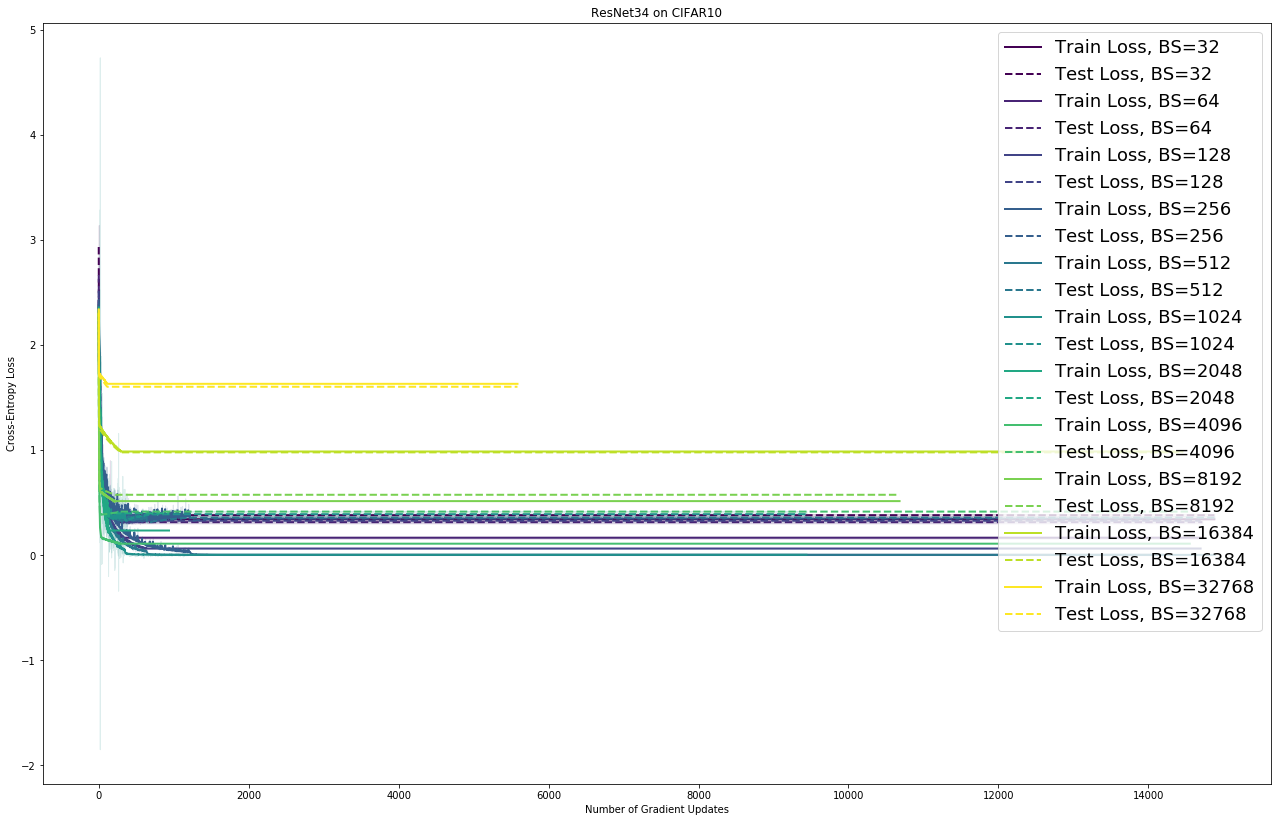

In [145]:
"""
PLOT ALL CURVES IN ONE FIGURE
"""
BEGIN = 0
all_bs_values = results[FIELDS_TO_PLOT[0]].keys()
bs_int_values = sorted(list(map(int, all_bs_values)))

plt.figure(figsize=(22,14))

color_idx = np.linspace(.0, 1., len(all_bs_values))

def plot_mean_and_CI(x_values, mean, lb, ub, color='red', linewidth=2, label='Test', linestyle='-'):
    # plot the shaded range of the confidence intervals
    plt.fill_between(x_values, ub, lb,
                     color=color, alpha=.15)
    # plot the mean on top
    plt.plot(x_values, mean, color=color, alpha=1.0, linewidth=linewidth, label=label, linestyle=linestyle)

for i, bs in zip(color_idx, bs_int_values):
    # ensure that field arrays are of save size here
    final_array_len = min([len(means[field][bs]) for field in FIELDS_TO_PLOT])
    print(final_array_len)
    for field in ALL_PLOT_FIELDS:
        all_bs_values = means[field].keys()
        y_values = means[field][bs][BEGIN:final_array_len]
        x_values = list(range(BEGIN, len(y_values) + BEGIN))
        label = "{0}, BS={1}".format(PRETTY_FIELD_NAMES[field], bs)
        lb = lower_confidence_intervals[field][bs]
        ub = upper_confidence_intervals[field][bs]
        j = 1
        plot_mean_and_CI(x_values[::j], y_values[::j], lb[::j], ub[::j], color=plt.cm.viridis(i), \
                        linewidth=2, label=label, linestyle=FIELD_LINETYPES[field])
        #plt.plot(x_values[::25], y_values[::25], alpha=.8, color=plt.cm.Dark2(i), \
        #         linewidth=2, label=label, linestyle=FIELD_LINETYPES[field])
        plt.xlabel('Number of Gradient Updates')
        plt.ylabel('Cross-Entropy Loss')

plt.title(TITLE)
plt.legend(loc='upper right', fontsize=18)
plt.plot()
plt.show()

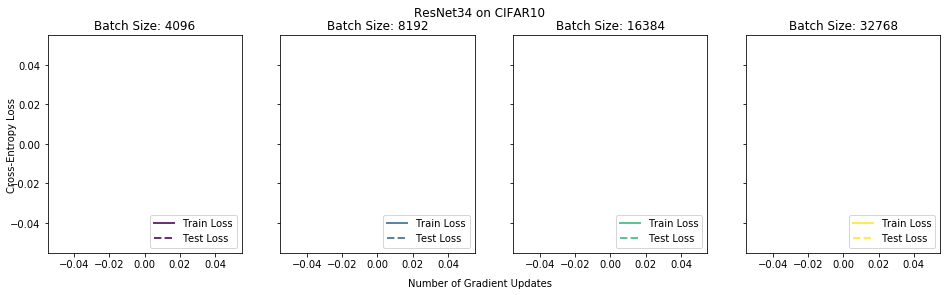

In [91]:
"""
PLOT ALL FIELDS WITH ONE FIGURE PER BATCH SIZE
"""
all_bs_values = results[FIELDS_TO_PLOT[0]].keys()
bs_int_values = sorted(list(map(int, all_bs_values)))

color_idx = np.linspace(.0, 1., len(all_bs_values))


f, axes = plt.subplots(1, len(bs_int_values), sharey=True)
f.set_figheight(4)
f.set_figwidth(16)
k = 0

for i, bs in zip(color_idx, bs_int_values):
    # ensure that field arrays are of save size here
    final_array_len = min([len(results[field][bs]) for field in FIELDS_TO_PLOT])
    for field in ALL_PLOT_FIELDS:
        all_bs_values = means[field].keys()
        BEGIN = 10
        y_values = means[field][bs][BEGIN:final_array_len]
        x_values = [x*10 for x in range(BEGIN, len(y_values) + BEGIN)]
        label = PRETTY_FIELD_NAMES[field]
        
        plt.figure(i)
        axes[k].plot(x_values[::25], y_values[::25], alpha=.8, color=plt.cm.viridis(i), \
                 linewidth=2, label=label, linestyle=FIELD_LINETYPES[field])
        axes[k].set_title('Batch Size: {}'.format(bs))
        axes[k].legend(loc='lower right')
        #axes[k].set_xlabel('Number of Gradient Updates')
        #plt.ylabel('Loss')
    k += 1

f.suptitle(TITLE)
f.text(0.5, 0.01, 'Number of Gradient Updates', ha='center')
f.text(0.09, 0.5, 'Cross-Entropy Loss', va='center', rotation='vertical')

plt.show()

Details:
   - Network: ResNet34
   - Dataset: CIFAR-10
   - Plain SGD, no momentum/weight decay. LR=.1, decay factor of .2 every epoch. Changed original hyperparameters by removing momentum/weight decay.
   - Trained 100 epochs on all networks. Can retrain to get same total number of updates for all batch sizes
   - Going to rerun this on a language modeling task with an LSTM, as well as a different architecture on CIFAR10 (probably DenseNet)

[88.218874273478136, 94.346278721278722, 97.799075924075922, 99.946056547619037, 99.958147321428569, 99.953999999999994, 91.69921875, 96.448000000000008, 82.332000000000008, 64.798000000000002, 38.593999999999994]
BS=32: 88.2188742735
BS=64: 94.3462787213
BS=128: 97.7990759241
BS=256: 99.9460565476
BS=512: 99.9581473214
BS=1024: 99.954
BS=2048: 91.69921875
BS=4096: 96.448
BS=8192: 82.332
BS=16384: 64.798
BS=32768: 38.594
[87.122857142857143, 89.987142857142857, 91.445714285714274, 92.866249999999994, 92.689999999999998, 91.534999999999997, 87.370000000000005, 87.760000000000005, 79.950000000000003, 64.840000000000003, 40.600000000000001]
BS=32: 87.1228571429
BS=64: 89.9871428571
BS=128: 91.4457142857
BS=256: 92.86625
BS=512: 92.69
BS=1024: 91.535
BS=2048: 87.37
BS=4096: 87.76
BS=8192: 79.95
BS=16384: 64.84
BS=32768: 40.6


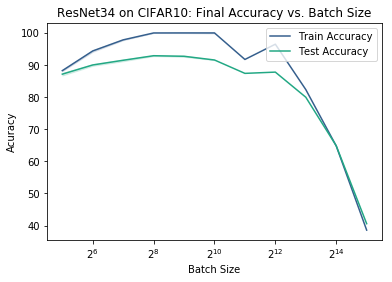

In [160]:
"""
PLOTTING FINAL TRAIN/TEST SCORE VS BATCH SIZE
"""
all_bs_values = results[FIELDS_TO_PLOT[0]].keys()
bs_int_values = sorted(list(map(int, all_bs_values)))

color_idx = np.linspace(.3, .6, len(FINAL_PLOT_FIELDS))

#f, axes = plt.subplots(1, 1, sharey=True)
#f.set_figheight(4)
#f.set_figwidth(8)

for i, field in zip(color_idx, FINAL_PLOT_FIELDS):
    values = means[field]
    final_field_values = [values[bs][-1] for bs in bs_int_values]
    
    final_ubs = [upper_confidence_intervals[field][bs][-1] for bs in bs_int_values]
    final_lbs = [lower_confidence_intervals[field][bs][-1] for bs in bs_int_values]
    for bs, val in zip(bs_int_values, final_field_values):
        print("BS={0}: {1}".format(bs,val))
    label = PRETTY_FIELD_NAMES[field]
    plt.fill_between(bs_int_values, final_ubs, final_lbs, color=plt.cm.viridis(i), alpha=.15)
    plt.semilogx(bs_int_values, final_field_values, linestyle='-', label=label, color=plt.cm.viridis(i), basex=2)

plt.title('{}: Final Accuracy vs. Batch Size'.format(TITLE))
plt.legend(loc='upper right')
plt.xlabel('Batch Size')
plt.ylabel('Acuracy')

plt.show()